In [12]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load data
df = pd.read_csv('/content/drive/MyDrive/ML_Project_2/data/train_dataset.csv')

print(f"Original Dataset Shape: {df.shape}")
print(f"Class Distribution:\n{df['smoking'].value_counts()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original Dataset Shape: (38984, 23)
Class Distribution:
smoking
0    24666
1    14318
Name: count, dtype: int64


1. From EDA we have found 5517 duplicates in the dataset. So, let's remove them first


In [13]:
print(f"\nDuplicates found: {df.duplicated().sum()}")

df_clean = df.drop_duplicates()

print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")
print(f"New shape: {df_clean.shape}")

# Verify
print(f"\nRemaining duplicates: {df_clean.duplicated().sum()}")
print("✓ Duplicates removed successfully!")


Duplicates found: 5517
Rows removed: 5517
New shape: (33467, 23)

Remaining duplicates: 0
✓ Duplicates removed successfully!


2. Separate into features and labels

In [14]:
X = df_clean.drop('smoking', axis=1)
y = df_clean['smoking']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")
print(f"\nTarget distribution:\n{y.value_counts()}")
print(f"\nClass imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")


Feature matrix shape: (33467, 22)
Target vector shape: (33467,)

Features: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']

Target distribution:
smoking
0    21209
1    12258
Name: count, dtype: int64

Class imbalance ratio: 1.73:1


There are features in the dataset that have very low variance and are not predictive so we can remove them

In [15]:
# Identify low-variance features that won't help models
print("\n" + "="*60)
print("STEP 3: ANALYZING FEATURE VARIANCE")
print("="*60)

# Calculate variance for each feature
variances = X.var().sort_values()
print("\nFeatures sorted by variance (lowest first):")
print(variances.head(15))

# Check percentage of most common value for each feature
print("\n" + "="*60)
print("FEATURES WITH LOW VARIABILITY")
print("="*60)

low_var_features = []
for col in X.columns:
    most_common_pct = (X[col].value_counts().iloc[0] / len(X)) * 100
    unique_values = X[col].nunique()

    if most_common_pct > 95:
        low_var_features.append({
            'Feature': col,
            'Most_Common_Pct': most_common_pct,
            'Unique_Values': unique_values,
            'Variance': X[col].var()
        })

if low_var_features:
    low_var_df = pd.DataFrame(low_var_features).sort_values('Most_Common_Pct', ascending=False)
    print(low_var_df)

    print(f"\n⚠️ Found {len(low_var_features)} features with >95% same value")
    print("These features have minimal predictive power and should be removed.")
else:
    print("✓ No extreme low-variance features found")

# Remove low-variance features
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
X_high_var = selector.fit_transform(X)

# Get remaining feature names
selected_features = X.columns[selector.get_support()].tolist()
removed_features = X.columns[~selector.get_support()].tolist()

print(f"\n" + "="*60)
print(f"VARIANCE THRESHOLD: {variance_threshold}")
print("="*60)
print(f"\nFeatures removed ({len(removed_features)}): {removed_features}")
print(f"Features retained ({len(selected_features)}): {len(selected_features)}")

# Update X with selected features
X = pd.DataFrame(X_high_var, columns=selected_features)

print(f"\nNew feature matrix shape: {X.shape}")
print("✓ Low-variance features removed")


STEP 3: ANALYZING FEATURE VARIANCE

Features sorted by variance (lowest first):
hearing(left)         0.024725
hearing(right)        0.025377
serum creatinine      0.049301
Urine protein         0.162416
dental caries         0.168603
eyesight(left)        0.246259
eyesight(right)       0.247872
hemoglobin            2.441136
height(cm)           84.563974
waist(cm)            86.686033
relaxation           93.548934
age                 145.727571
weight(kg)          165.841735
systolic            186.896752
HDL                 213.102232
dtype: float64

FEATURES WITH LOW VARIABILITY
          Feature  Most_Common_Pct  Unique_Values  Variance
0   hearing(left)        97.463173              2  0.024725
1  hearing(right)        97.394448              2  0.025377

⚠️ Found 2 features with >95% same value
These features have minimal predictive power and should be removed.

VARIANCE THRESHOLD: 0.01

Features removed (0): []
Features retained (22): 22

New feature matrix shape: (33467, 22)


Using Z-score method to handle the outliers in the dataset

In [17]:
# Handle outliers using Z-score method (removes rows with extreme values)
from scipy import stats

print(f"Original data shape: {X.shape}")

# Calculate z-scores for all features
z_scores = np.abs(stats.zscore(X))

# Remove rows where any feature has |z-score| > 3
threshold = 3
outlier_rows = (z_scores > threshold).any(axis=1)

X_cleaned = X[~outlier_rows]
y_cleaned = y[~outlier_rows]

print(f"\nOutlier threshold: Z-score > {threshold}")
print(f"Rows with outliers detected: {outlier_rows.sum()}")
print(f"Rows removed: {outlier_rows.sum()} ({(outlier_rows.sum()/len(X)*100):.2f}%)")
print(f"\nCleaned data shape: {X_cleaned.shape}")
print(f"Samples retained: {len(X_cleaned)} ({(len(X_cleaned)/len(X)*100):.2f}%)")

# Check which features had most outliers
outlier_count_by_feature = (z_scores > threshold).sum(axis=0)
outlier_df = pd.DataFrame({
    'Feature': X.columns,
    'Outlier_Count': outlier_count_by_feature
}).sort_values('Outlier_Count', ascending=False)

print("\nFeatures with most outliers removed:")
print(outlier_df.head(10))

print("\n✓ Outliers removed using Z-score method")

# Update X and y for next steps
X = X_cleaned.reset_index(drop=True)
y = y_cleaned.reset_index(drop=True)

Original data shape: (33467, 22)

Outlier threshold: Z-score > 3
Rows with outliers detected: 4922
Rows removed: 4922 (14.71%)

Cleaned data shape: (28545, 22)
Samples retained: 28545 (85.29%)

Features with most outliers removed:
                Feature  Outlier_Count
7        hearing(right)            872
6         hearing(left)            849
16        Urine protein            776
10  fasting blood sugar            603
12         triglyceride            542
20                  Gtp            533
15           hemoglobin            323
18                  AST            297
13                  HDL            290
2            weight(kg)            249

✓ Outliers removed using Z-score method


3. Handling outliers using the IQR (Interquartile range method) <br> This method calculates the interquartile range (IQR) of the data, and any observation that falls outside of the lower and upper limits of the box plot, which are defined as Q1–1.5 * IQR and Q3 + 1.5 * IQR, respectively, is considered an outlier.

In [9]:
# X_capped = X.copy()

# outlier_info = []

# for col in X.columns:
#     Q1 = X[col].quantile(0.25)
#     Q3 = X[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Count outliers before capping
#     outliers_before = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()

#     # Cap outliers
#     X_capped[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

#     outlier_info.append({
#         'Feature': col,
#         'Outliers_Capped': outliers_before,
#         'Lower_Bound': lower_bound,
#         'Upper_Bound': upper_bound
#     })

# outlier_df = pd.DataFrame(outlier_info).sort_values('Outliers_Capped', ascending=False)
# print("\nTop 10 features with capped outliers:")
# print(outlier_df.head(10))

# print(f"\n✓ Outliers capped using IQR method (preserves data size)")
# print(f"Total outlier values capped: {outlier_df['Outliers_Capped'].sum()}")


Top 10 features with capped outliers:
                Feature  Outliers_Capped  Lower_Bound  Upper_Bound
21        dental caries             7185          0.0          0.0
20                  Gtp             2901        -23.5         84.5
19                  ALT             2255         -9.0         55.0
10  fasting blood sugar             1987         66.5        126.5
17     serum creatinine             1905          0.5          1.3
16        Urine protein             1844          1.0          1.0
18                  AST             1800          4.0         44.0
12         triglyceride             1412        -52.5        287.5
7        hearing(right)              872          1.0          1.0
6         hearing(left)              849          1.0          1.0

✓ Outliers capped using IQR method (preserves data size)
Total outlier values capped: 28126


In [19]:
X_cleaned.head() # final cleaned data

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
4,20.0,165.0,60.0,81.0,1.5,0.1,1.0,1.0,109.0,64.0,...,200.0,47.0,92.0,14.9,1.0,1.2,26.0,28.0,15.0,0.0
6,40.0,175.0,90.0,95.0,0.9,1.0,1.0,1.0,130.0,88.0,...,331.0,39.0,102.0,16.5,1.0,1.0,19.0,22.0,19.0,0.0
7,40.0,180.0,75.0,85.0,1.5,1.5,1.0,1.0,110.0,60.0,...,62.0,58.0,99.0,14.0,2.0,1.4,29.0,20.0,32.0,1.0
8,40.0,170.0,60.0,74.0,1.2,1.5,1.0,1.0,89.0,57.0,...,69.0,60.0,104.0,12.9,2.0,0.7,17.0,17.0,14.0,0.0
9,45.0,155.0,55.0,78.0,0.7,1.0,1.0,1.0,114.0,81.0,...,177.0,41.0,107.0,13.1,1.0,0.6,22.0,15.0,56.0,0.0


4. Feature Scaling for distance sensitive models.


Scaling Method: StandardScaler (zero mean, unit variance)

Scaled feature statistics:
      age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
mean  0.0        -0.0         0.0       -0.0             0.0             -0.0   
std   1.0         1.0         1.0        1.0             1.0              1.0   

      hearing(left)  hearing(right)  systolic  relaxation  ...  triglyceride  \
mean            0.0             0.0       0.0         0.0  ...          -0.0   
std             0.0             0.0       1.0         1.0  ...           1.0   

      HDL  LDL  hemoglobin  Urine protein  serum creatinine  AST  ALT  Gtp  \
mean -0.0  0.0         0.0            0.0               0.0 -0.0 -0.0 -0.0   
std   1.0  1.0         1.0            1.0               1.0  1.0  1.0  1.0   

      dental caries  
mean           -0.0  
std             1.0  

[2 rows x 22 columns]

✓ Features scaled successfully!


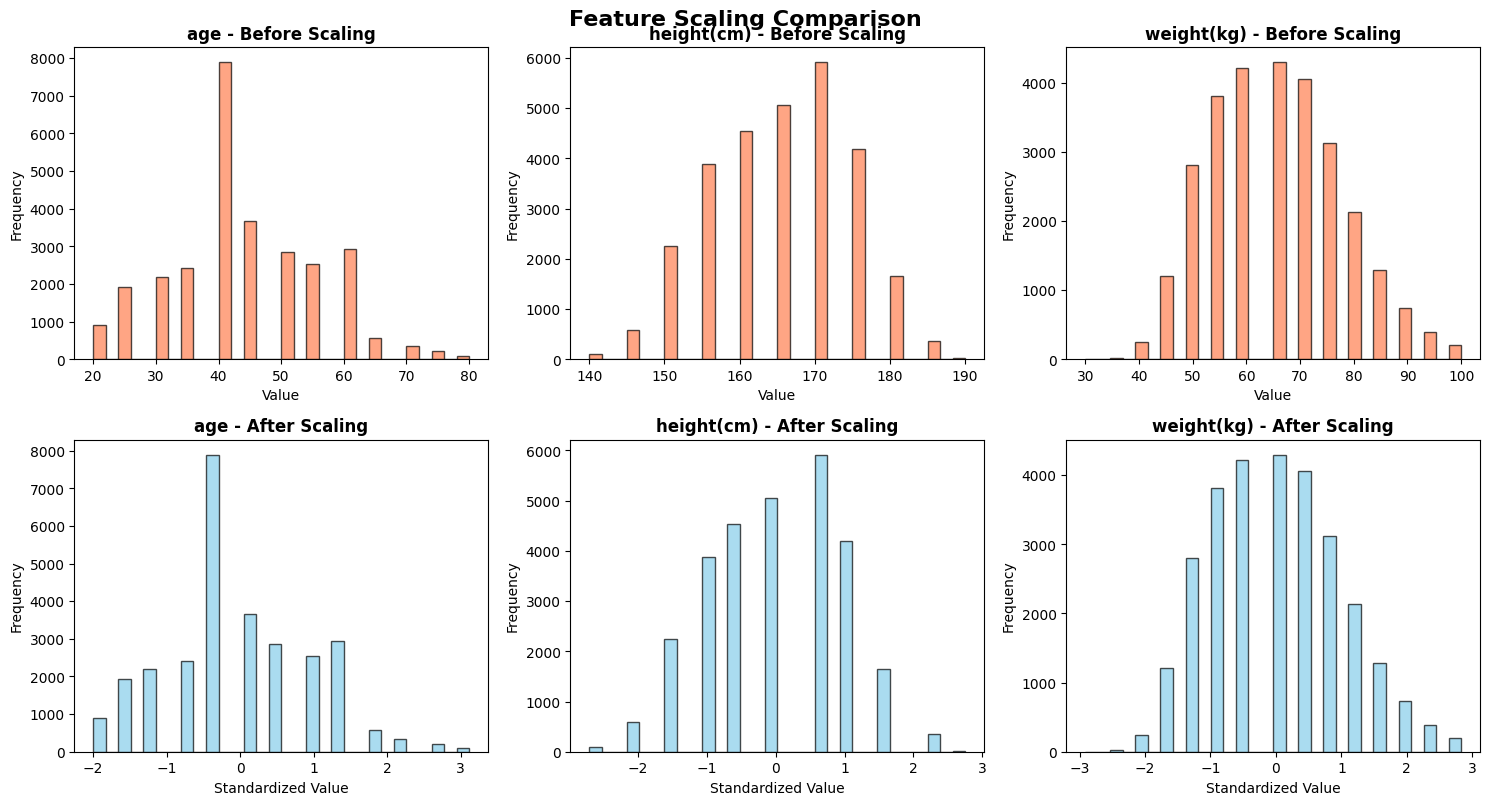

In [20]:
# Apply StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to dataframe for inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nScaling Method: StandardScaler (zero mean, unit variance)")
print(f"\nScaled feature statistics:")
print(X_scaled_df.describe().loc[['mean', 'std']].round(4))

print("\n✓ Features scaled successfully!")

# Visualize before/after scaling (sample features)
if len(X.columns) >= 3:
    sample_features = X.columns[:3]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for idx, col in enumerate(sample_features):
        col_idx = X.columns.get_loc(col)
        # Before scaling
        axes[0, idx].hist(X[col], bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[0, idx].set_title(f'{col} - Before Scaling', fontweight='bold')
        axes[0, idx].set_xlabel('Value')
        axes[0, idx].set_ylabel('Frequency')

        # After scaling
        axes[1, idx].hist(X_scaled[:, col_idx], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
        axes[1, idx].set_title(f'{col} - After Scaling', fontweight='bold')
        axes[1, idx].set_xlabel('Standardized Value')
        axes[1, idx].set_ylabel('Frequency')

    plt.tight_layout()
    plt.suptitle('Feature Scaling Comparison', fontsize=16, fontweight='bold', y=1.001)
    plt.show()

![image.png]()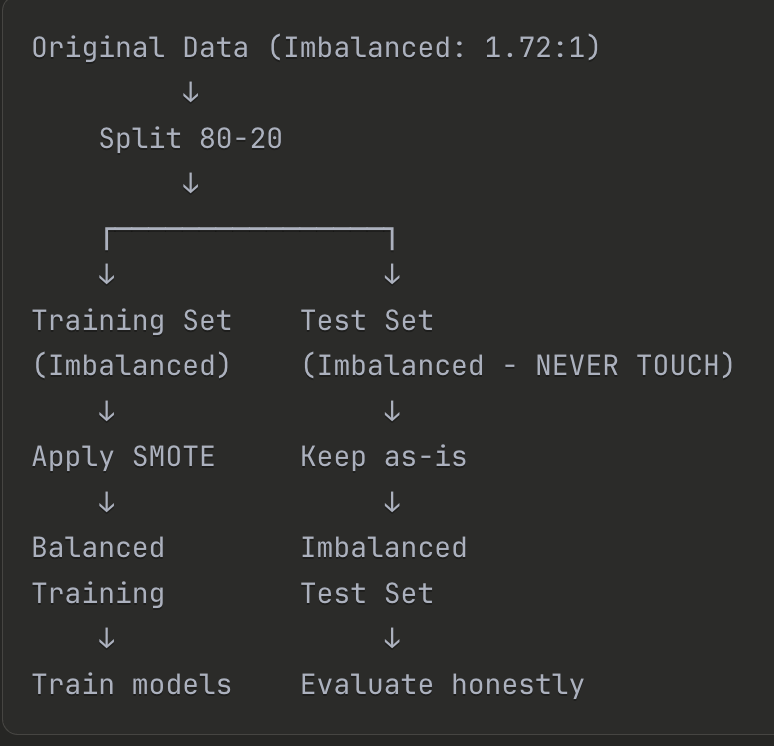

We need to handle the imbalance in the dataset.
First we separate the test data set. We don't apply smote before that since we want the test dataset to represent the imbalance in the real dataset at production time.

In [22]:
# Split data BEFORE applying SMOTE

print("\n" + "="*60)
print("STEP 6: TRAIN-TEST SPLIT")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())
print(f"Proportion: {pd.Series(y_train).value_counts(normalize=True).round(3).to_dict()}")

print(f"\nTest set class distribution:")
print(pd.Series(y_test).value_counts())
print(f"Proportion: {pd.Series(y_test).value_counts(normalize=True).round(3).to_dict()}")

print("\n✓ Stratified split maintains class proportions in both sets")


STEP 6: TRAIN-TEST SPLIT

Training set size: 22836
Test set size: 5709

Training set class distribution:
smoking
0    14660
1     8176
Name: count, dtype: int64
Proportion: {0: 0.642, 1: 0.358}

Test set class distribution:
smoking
0    3665
1    2044
Name: count, dtype: int64
Proportion: {0: 0.642, 1: 0.358}

✓ Stratified split maintains class proportions in both sets


Applying SMOTE to train data.


Before SMOTE:
Training set shape: (22836, 22)
Class distribution:
smoking
0    14660
1     8176
Name: count, dtype: int64

After SMOTE:
Training set shape: (29320, 22)
Class distribution:
smoking
1    14660
0    14660
Name: count, dtype: int64


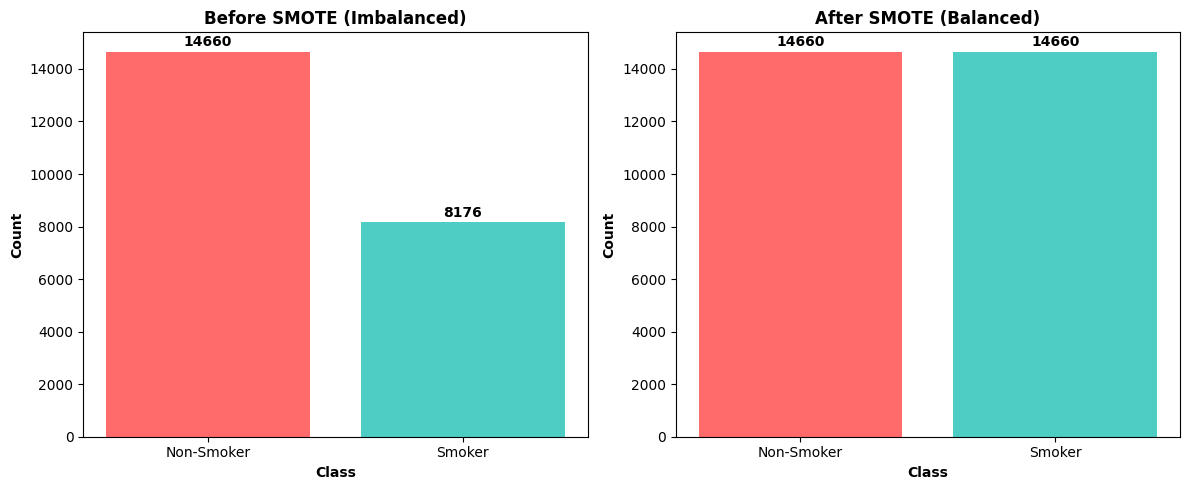


✓ Training data balanced using SMOTE
⚠️ Note: Test set remains imbalanced (real-world distribution)


In [23]:
print(f"\nBefore SMOTE:")
print(f"Training set shape: {X_train.shape}")
print(f"Class distribution:\n{pd.Series(y_train).value_counts()}")

# Apply SMOTE
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training set shape: {X_train_balanced.shape}")
print(f"Class distribution:\n{pd.Series(y_train_balanced).value_counts()}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
before_counts = pd.Series(y_train).value_counts()
axes[0].bar([0, 1], before_counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[0].set_xlabel('Class', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_title('Before SMOTE (Imbalanced)', fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Smoker', 'Smoker'])
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

# After SMOTE
after_counts = pd.Series(y_train_balanced).value_counts()
axes[1].bar([0, 1], after_counts.values, color=['#FF6B6B', '#4ECDC4'])
axes[1].set_xlabel('Class', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('After SMOTE (Balanced)', fontweight='bold')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Smoker', 'Smoker'])
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Training data balanced using SMOTE")
print("⚠️ Note: Test set remains imbalanced (real-world distribution)")

Saving the preprocessed dataset for model training.

In [25]:
# Save preprocessed data for modeling
print("\n" + "="*60)
print("STEP 8: SAVING PREPROCESSED DATA")
print("="*60)

import pickle

# Save scaler for future use
with open('/content/drive/MyDrive/ML_Project_2/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler saved")

# Save feature names
with open('/content/drive/MyDrive/ML_Project_2/models/feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print("✓ Feature names saved")

# Save preprocessed datasets
np.save('/content/drive/MyDrive/ML_Project_2/data/X_train_balanced.npy', X_train_balanced)
np.save('/content/drive/MyDrive/ML_Project_2/data/y_train_balanced.npy', y_train_balanced)
np.save('/content/drive/MyDrive/ML_Project_2/data/X_test.npy', X_test)
np.save('/content/drive/MyDrive/ML_Project_2/data/y_test.npy', y_test)
print("✓ Train and test sets saved")

# Also save unbalanced training set (for comparison)
np.save('/content/drive/MyDrive/ML_Project_2/data/X_train_unbalanced.npy', X_train)
np.save('/content/drive/MyDrive/ML_Project_2/data/y_train_unbalanced.npy', y_train)
print("✓ Unbalanced training set saved (for comparison experiments)")

print("\nAll preprocessed data saved to Drive!")


STEP 8: SAVING PREPROCESSED DATA
✓ Scaler saved
✓ Feature names saved
✓ Train and test sets saved
✓ Unbalanced training set saved (for comparison experiments)

All preprocessed data saved to Drive!


In [26]:
# Final summary
print("\n" + "="*60)
print("PREPROCESSING SUMMARY")
print("="*60)

print("\n📊 DATA TRANSFORMATIONS APPLIED:")
print(f"   1. ✓ Removed {df.shape[0] - df_clean.shape[0]} duplicate rows")
print(f"   2. ✓ Removed {len(removed_features)} low-variance features")
print(f"   3. ✓ Handled outliers (Z-score or IQR method)")
print(f"   4. ✓ Scaled {X.shape[1]} features using StandardScaler")
print(f"   5. ✓ Split data: 80% train, 20% test")
print(f"   6. ✓ Balanced training set with SMOTE")

print("\n📁 FINAL DATASET SIZES:")
print(f"   • X_train_balanced: {X_train_balanced.shape}")
print(f"   • y_train_balanced: {y_train_balanced.shape}")
print(f"   • X_test: {X_test.shape}")
print(f"   • y_test: {y_test.shape}")

print("\n🔧 FEATURES USED:")
print(f"   • Original features: {df.shape[1] - 1}")
print(f"   • Features after variance filtering: {X.shape[1]}")
print(f"   • Removed features: {removed_features}")

print("\n🎯 READY FOR MODELING:")
print("   • Logistic Regression")
print("   • Support Vector Machine (SVM)")
print("   • Neural Networks")

print("\n💾 FILES SAVED:")
print("   • scaler.pkl")
print("   • feature_names.pkl")
print("   • X_train_balanced.npy")
print("   • y_train_balanced.npy")
print("   • X_test.npy")
print("   • y_test.npy")

print("\n" + "="*60)
print("✅ PREPROCESSING COMPLETE!")
print("="*60)


PREPROCESSING SUMMARY

📊 DATA TRANSFORMATIONS APPLIED:
   1. ✓ Removed 5517 duplicate rows
   2. ✓ Removed 0 low-variance features
   3. ✓ Handled outliers (Z-score or IQR method)
   4. ✓ Scaled 22 features using StandardScaler
   5. ✓ Split data: 80% train, 20% test
   6. ✓ Balanced training set with SMOTE

📁 FINAL DATASET SIZES:
   • X_train_balanced: (29320, 22)
   • y_train_balanced: (29320,)
   • X_test: (5709, 22)
   • y_test: (5709,)

🔧 FEATURES USED:
   • Original features: 22
   • Features after variance filtering: 22
   • Removed features: []

🎯 READY FOR MODELING:
   • Logistic Regression
   • Support Vector Machine (SVM)
   • Neural Networks

💾 FILES SAVED:
   • scaler.pkl
   • feature_names.pkl
   • X_train_balanced.npy
   • y_train_balanced.npy
   • X_test.npy
   • y_test.npy

✅ PREPROCESSING COMPLETE!
